# ch4  
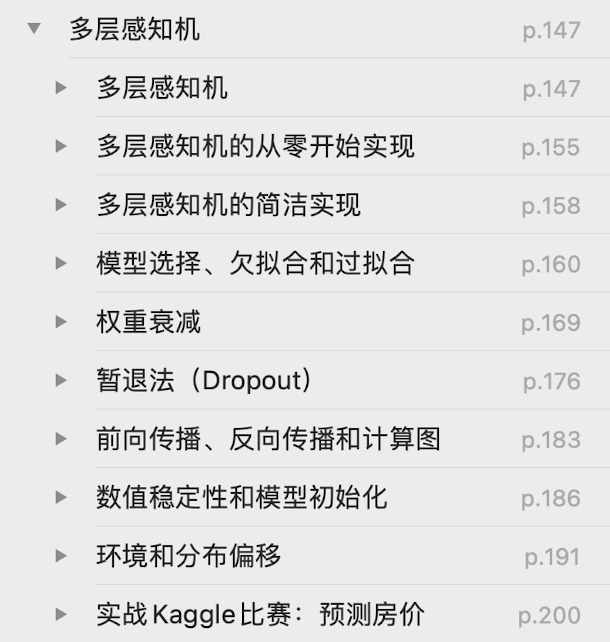

In [29]:
%matplotlib inline
import torch
import d2l.torch as d2l
from torch import nn
import math
import numpy as np

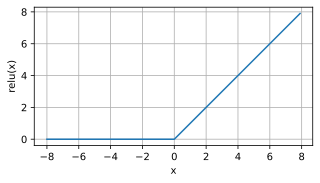

In [9]:
x = torch.arange(-8.0,8.0,0.1,requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach().numpy(),y.detach().numpy(),'x','relu(x)',figsize=(5,2.5))

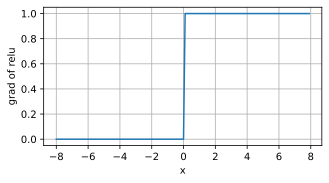

In [10]:
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(),x.grad,'x','grad of relu',figsize=(5,2.5))

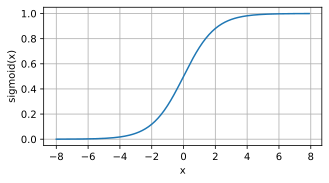

In [11]:
y = torch.sigmoid(x)
d2l.plot(x.detach(),y.detach(),'x','sigmoid(x)',figsize=(5,2.5))

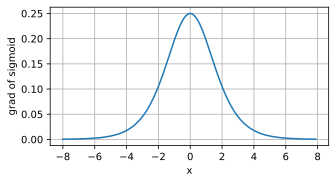

In [12]:
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(),x.grad,'x','grad of sigmoid',figsize=(5,2.5))

$ \mathrm{tanh(x)} = \frac{1- \exp(-2x)}{1 + \exp(-2x)} $

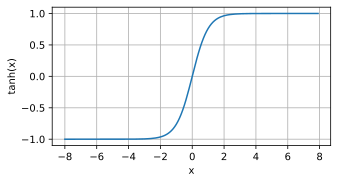

In [14]:
y = torch.tanh(x)
d2l.plot(x.detach(),y.detach(),'x','tanh(x)',figsize=(5,2.5))

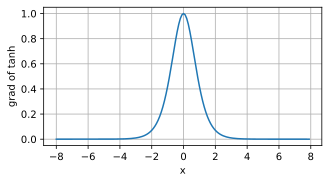

In [17]:
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(),x.grad,'x','grad of tanh',figsize=(5,2.5))

## 4.2 多层感知机从零开始

In [19]:
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)

In [20]:
num_inputs,num_outputs,num_hiddens = 784,10,256

W1 = nn.Parameter(torch.randn(
    num_inputs,num_hiddens,requires_grad=True)*0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens,requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens,num_outputs,requires_grad=True)*0.01)
b2 = nn.Parameter(torch.zeros(num_outputs,requires_grad=True))

params = [W1,b1,W2,b2]

In [21]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X,a)

In [22]:
def net(X):
    X = X.reshape((-1,num_inputs))
    H = relu(X@W1 + b1)
    return (H@W2 + b2)

In [23]:
loss = nn.CrossEntropyLoss(reduction='none')

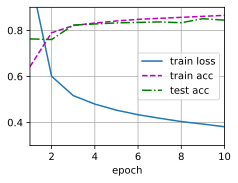

In [24]:
num_epochs,lr = 10,0.1
updater = torch.optim.SGD(params,lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,updater)

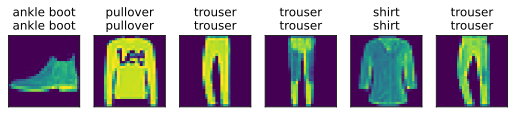

In [25]:
d2l.predict_ch3(net,test_iter)

## 4.3 多层感知机的简洁实现

In [26]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,256),
    nn.ReLU(),
    nn.Linear(256,10)
)
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [27]:
batch_size,lr,num_epochs = 256,0.1,10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(),lr=lr)

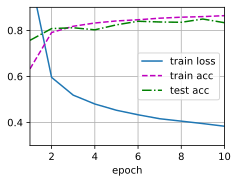

In [28]:
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

## 4.4.4 多项式回归

In [35]:
max_degree = 20
n_train,n_test = 100,100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size=(n_train + n_test ,1))
np.random.shuffle(features)
poly_features = np.power(features,np.arange(max_degree).reshape(1,-1)) # 广播机制 每项取20次幂
for i in range(max_degree):
    poly_features[:,] /= math.gamma(i+1)  # gamma(n)=(n-1)! # 每项按照阶乘缩放
# labels的维度：(n_train + n_test,)
labels = np.dot(poly_features,true_w)
labels += np.random.normal(scale=0.1,size=labels.shape) #scale=0.1 缩放因子 标准差变为0.1

In [36]:
true_w,features,poly_features,labels = [torch.tensor(x,dtype=
                                        torch.float32 ) for x in [true_w,features,poly_features,labels]]

In [37]:
features[:2],poly_features[:2,:],labels[:2]

(tensor([[-1.5236],
         [ 1.2089]]),
 tensor([[0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([0.0635, 0.0464]))

In [38]:
def evaluate_loss(net,data_iter,loss):
    metric = d2l.Accumulator(2)
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l=loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]

In [40]:
def train(train_features,test_features,train_labels,test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(
        nn.Linear(input_shape,1,bias=False)
        )
    batch_size = min(10,train_labels.shape[0])
    train_iter = d2l.load_array((train_features,train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features,test_labels.reshape(-1,1)),
                                batch_size,is_train=False)
    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',
                            xlim=[1,num_epochs],ylim=[1e-3,1e2],
                            legend=['train','test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net,train_iter,loss,trainer)
        if epoch ==0 or (epoch + 1)%20==0:
            animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),
                                  evaluate_loss(net,test_iter,loss)))
    print('weight:',net[0].weight.data.numpy())

weight: [[ 0.17747408 -0.32243848  0.20213807 -0.03346294]]


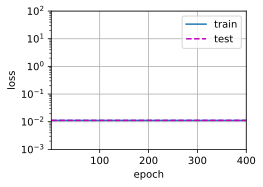

In [41]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train,:4],poly_features[n_train:,:4],
      labels[:n_train],labels[n_train:])#?

weight: [[-0.03198665 -0.6610599 ]]


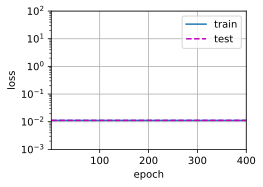

In [42]:
train(poly_features[:n_train,:2],poly_features[n_train:,:2],
      labels[:n_train],labels[n_train:])
#? 代码曲线 奇怪得很 下次再看 不如直接看有问题的地方了
# 难搞 因为真的很多不明白的

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x20 and 1x1)

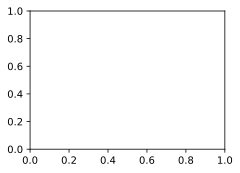

In [43]:
# 列表的切片还真是奇奇怪怪
train(poly_features[:n_train,:1],poly_features[n_train:,:],
      labels[:n_train],labels[n_train:],num_epochs=1500)

# 4.5 权重衰减

In [44]:
n_train,n_test,num_inputs,batch_size=20,100,200,5
true_w,true_b = torch.ones((num_inputs,1))*0.01,0.05

train_data = d2l.synthetic_data(true_w,true_b,n_train)
train_iter = d2l.load_array(train_data,batch_size)

test_data = d2l.synthetic_data(true_w,true_b,n_test)
test_iter = d2l.load_array(test_data,batch_size,is_train=False)

## 4.5.2 从零开始实现

In [45]:
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)
    return [w,b]

In [46]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [47]:
def train(lambd):
    w,b = init_params()
    net,loss = lambda X:d2l.linreg(X,w,b),d2l.squared_loss
    num_epochs,lr=100,0.003
    animator = d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',
                            xlim=[5,num_epochs],legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X),y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w,b],lr,batch_size)
        if (epoch + 1) %5 ==0:
            animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),
                                  d2l.evaluate_loss(net,test_iter,loss)))
            
    print('w的L2范数是：',torch.norm(w).item())

w的L2范数是： 12.554012298583984


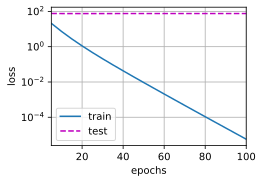

In [48]:
train(lambd=0)

w的L2范数是： 0.36597391963005066


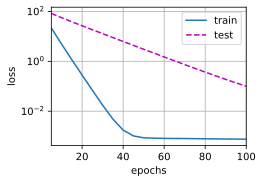

In [49]:
train(lambd=3)

In [50]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs,lr=100,0.003

    trainer = torch.optim.SGD([
        {'params':net[0].weight,'weight_decay':wd},
        {'params':net[0].bias}
    ],lr=lr)

    animator = d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',
                            xlim=[5,num_epochs],legend=['train','test'])
    
    for epoch in range(num_epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.mean().backward()
            trainer.step()
        if (epoch+1)%5 == 0:
            animator.add(epoch+1,
                         (d2l.evaluate_loss(net,train_iter,loss),
                         d2l.evaluate_loss(net,test_iter,loss)))
    print('w的L2范数：',net[0].weight.norm().item())

w的L2范数： 14.647480964660645


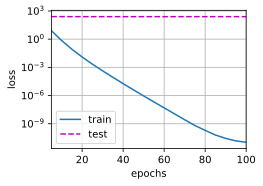

In [51]:
train_concise(0)

w的L2范数： 0.4114062488079071


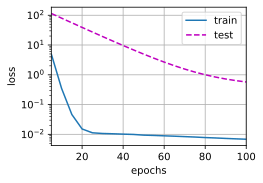

In [52]:
train_concise(3)